# <center> Infer SAM/ MedSAM models on histological data </center>

#### <center> Note : create a conda environment with segment_anything and histomics modules installed as well as Cytowmine </center>
##### <center> (requirements for SAM: pytorch >=1.7, torchvision>=0.8) </center>

# Load SAM model checkpoint

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from histomics.data.datasets.from_database.nuclick_validation_dataset import (
    NUCLICK_TILES_GT_QUERY,
    NuclickValidationFromDataBase,
)
from skimage import io, transform
from histomics.data.io.torch_dataset import TrainDataset
from histomics.data.transforms.label_transforms import (
    NuclickRandomCentroidLabelTransform,
)
from histomics.data.transforms.model_image_transforms import DummyTransform
from tqdm import tqdm
# Basic viz functions
from typing import Any
from loguru import logger

from segment_anything.sam_histomics.sam_inferer import SamInferer

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


/home/owkin/envs/sam/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/owkin/envs/sam/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Load model (SAM)

In [ ]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda:0"

sam = sam_model_registry[model_type](checkpoint=f"/home/owkin/sam_weights/{sam_checkpoint}")
sam.to(device=device)

predictor = SamPredictor(sam)

#### Load model (MedSAM)

In [ ]:
medsam_checkpoint = "medsam_point_prompt_flare22.pth"
medsam_model_type = "vit_b"

medsam_model = sam_model_registry[medsam_model_type](checkpoint=f"/home/owkin/sam_weights/{medsam_checkpoint}")


device = "cuda:1"
medsam_model.to(device=device)
medsam_model.eval()

#### Instantiate a dataset from the database (using the `NuclickValidationFromDatabase` class)

In [ ]:
db_path = "/home/owkin/project/database/ground_truth_tiles.db"
root_path = f"sqlite:///{db_path}"
 

# TILE 67912873: annotated by Katharina, not by T.Rialland

TILES_GT_DB_INCLUDE = "(3521541,6619042,65331257,84715806,96202074,67912873)"

NUCLICK_TILES_GT_QUERY = (
    "SELECT tiles.tile_id,"
    " tiles.coords,tiles.slide_name,slides.abstra_slide_path,"
    " annotators.cytomine_username, tiles.timestamp_pushed,"
    " tiles.timestamp_row_creation, tiles.timestamp_pulled FROM slides"
    " INNER JOIN tiles ON tiles.slide_name=slides.slide_name"
    " INNER JOIN annotators ON tiles.annotator_id=annotators.annotator_id"
    " WHERE tiles.annotation_type IN ('_Priority_High','_Priority_Med','_Priority_Low')"
    f" AND tiles.is_pulled_from_cytomine=1 AND tiles.tile_id IN {TILES_GT_DB_INCLUDE}"
)

dataset_db = NuclickValidationFromDataBase(root_path=root_path, debug=False, sql_query=NUCLICK_TILES_GT_QUERY)

label_transform = NuclickRandomCentroidLabelTransform(0.1)

In [ ]:
# Check that all tiles are in the database
dataset_db.dataframe

In [ ]:
# Create a train dataset for inference

dataset_valid = TrainDataset(
        dataset_db,
        label_transform=label_transform,
        model_transform=DummyTransform(),
    )

# Create a Dataloader

dataloader = DataLoader(
            dataset=dataset_valid,
            shuffle=False,
            batch_size=1,
            collate_fn=None,
            drop_last=False,
        )

In [ ]:
dataloader_iterable = iter(dataloader)

In [ ]:
batch = next(dataloader_iterable)

In [ ]:
len(batch)

In [ ]:
batch[0].shape

In [ ]:
batch[2][0]

In [ ]:
batch[1].keys()

In [ ]:
batch[1]["centroids"].shape

In [ ]:
img_numpy = np.squeeze(batch[0].cpu().numpy()).transpose(1, 2, 0)

In [ ]:
plt.imshow(img_numpy)
points = np.squeeze(batch[1]["centroids"].cpu().numpy())
for point in points:
    plt.scatter(point[0], point[1], c="r")

## Predict using a single point

In [ ]:
predictor.set_image(img_numpy)

In [ ]:
point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy())
nb_points = point_coords.shape[0]
all_masks = [] # Predict one mask per input


for i in range(nb_points):
    input_label = np.zeros(nb_points)
    input_label[i] = 1
    
    mask, _, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=input_label,
        multimask_output=False,
    )
    all_masks.append(mask)



In [ ]:
idx_point = 10

point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy())
nb_points = point_coords.shape[0]

input_label = np.zeros(nb_points)
input_label[idx_point] = 1

masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
masks.shape

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img_numpy)
    
    show_mask(mask, plt.gca())
    show_points(point_coords, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:
predictor.set_image(img_numpy)

In [ ]:
# Inference with ONLY ONE point

idx_point = 10

point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy())[[idx_point], :]
nb_points = point_coords.shape[0]

input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img_numpy)
    show_mask(mask, plt.gca())
    show_points(point_coords, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## Infer on each point independently and plot

In [ ]:
def infer_sam_on_tile(predictor: SamPredictor, batch: tuple[torch.Tensor, dict[str, Any], tuple[str]]) -> list[np.ndarray]:
    """Given an input batch, infer SAM on each point
    and return all the masks corresponding to the predictions."""
    img_numpy = np.squeeze(batch[0].cpu().numpy()).transpose(1, 2, 0) # (H, W, C)
    predictor.set_image(img_numpy)
    point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy()) # (B, N_POINTS, 2)
    nb_points = point_coords.shape[0]
    all_masks = []

    for i in tqdm(range(nb_points)):
        input_label = np.array([1])
        masks, scores, logits = predictor.predict(
            point_coords=point_coords[[i], :],
            point_labels=input_label,
            multimask_output=True,
        )

        mask_max_score = masks[np.argmax(scores)]

        if mask_max_score.astype(int).sum() > mask_max_score.shape[0]*mask_max_score.shape[1]*0.3:
            logger.warning(f"Mask is too large for point {i}, skipping.")
        else:
            all_masks.append(mask_max_score)
    
    return all_masks


In [ ]:
def batch_inference_sam(predictor: SamPredictor, batch: tuple[torch.Tensor, dict[str, Any], tuple[str]]):
    """Perform batch inference."""
    img_numpy = np.squeeze(batch[0].cpu().numpy()).transpose(1, 2, 0) # (H, W, C)
    predictor.set_image(img_numpy)

    point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy()) # (N_POINTS, 2)
    labels = np.ones(point_coords.shape[1]) # (N_POINTS,)

    predictor.predict_torch(point_coords, )



In [ ]:
def infer_medsam_on_tile(medsam_model, batch: tuple[torch.Tensor, dict[str, Any], tuple[str]]) -> np.ndarray:
    """Infer Medsam on an incoming batch."""

    device = medsam_model.device
    img_numpy = np.squeeze(batch[0].cpu().numpy()).transpose(1, 2, 0) # (H, W, C)
    point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy()) # (N_POINTS, 2) # (x,y)
    H, W = img_numpy.shape[:2]

    # Preprocessing for the input image
    img_1024 = transform.resize(
        img_numpy, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    ) # (1, 3, 1024, 1024)


    # Transform the points to 1024x1024 space
    points_1024 = point_coords / np.array([W, H]) * 1024


    all_segs = []

    # Inference on the model right now
    with torch.no_grad():
        points_torch = torch.as_tensor(points_1024, dtype=torch.float, device=device) # (N_POINTS, 2)

        for i in range(points_torch.shape[0]):

            image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

        
            this_point = points_torch[[i], None, :] # (1, 1, 2)

            this_label = torch.ones((1, 1), device=device) # (1, 1)

            sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
            points=(this_point, this_label),
            boxes=None,
            masks=None,
            )

            low_res_logits, _ = medsam_model.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
            )

            low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

            low_res_pred = F.interpolate(
                    low_res_pred,
                    size=(H, W),
                    mode="bilinear",
                    align_corners=False,
                )  # (1, 1, gt.shape)
            low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
            medsam_seg = (low_res_pred > 0.5).astype(np.uint8)

            if medsam_seg.astype(int).sum() > medsam_seg.shape[0]*medsam_seg.shape[1]*0.3:
                logger.warning(f"Mask is too large for point {i}, skipping.")
            else:
                all_segs.append(medsam_seg)


    return all_segs, img_numpy, point_coords


In [ ]:
seg_medsam, img_numpy, point_coords = infer_medsam_on_tile(medsam_model, batch)

In [ ]:
len(seg_medsam)

In [ ]:
labels = np.ones(point_coords.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_numpy)
show_points(point_coords, labels, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_numpy)

for mask in seg_medsam:
    show_mask(mask, ax[1], random_color=True)
show_points(point_coords, labels, ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

In [ ]:
all_masks = infer_sam_on_tile(predictor, batch)

In [ ]:
def masks_list_to_instance_map(masks: list[np.ndarray], point_coords: np.ndarray) -> np.ndarray:
    """Given a list of masks and the corresponding point coordinates, create an instance map."""
    instance_map = np.zeros(masks[0].shape)
    for i, mask in enumerate(masks):
        x, y = point_coords[i]
        mask = mask.astype(int)
        mask[mask > 0] = i + 1
        instance_map += mask
    return instance_map

In [ ]:
point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy())
nb_points = point_coords.shape[0]
all_masks = []

for i in range(nb_points):
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=point_coords[[i], :],
        point_labels=input_label,
        multimask_output=True,
    )

    mask_max_score = masks[np.argmax(scores)]

    if mask_max_score.astype(int).sum() > mask.shape[0]*mask.shape[1]*0.3:
        logger.warning(f"Mask is too large for point {i}, skipping.")
    else:
        all_masks.append(mask_max_score)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img_numpy)

point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy()) # (1, N_POINTS, 2)
nb_points = point_coords.shape[0]

for mask in all_masks:
    show_mask(mask, plt.gca(), random_color=True)

input_label = np.ones(nb_points)
show_points(point_coords, input_label, plt.gca(), marker_size=200)
plt.suptitle(f"Tile id {batch[2][0]}")
plt.axis('off')
plt.show()

# Batch inference and comparison

In [ ]:
point_coords = torch.from_numpy(np.expand_dims(np.squeeze(batch[1]["centroids"].cpu().numpy()), axis=1)) # (B, N_POINTS, 2) -> HERE B = N_POINTS & N_POINTS = 1


transformed_coords = predictor.transform.apply_coords_torch(point_coords, original_size=(448, 448))

transformed_coords = transformed_coords.to(predictor.device)
print(transformed_coords.shape)

labels = torch.ones(transformed_coords.shape[0], 1, device=predictor.device)# (B, N_POINTS) -> (N_POINTS, 1)

masks, scores, _ = predictor.predict_torch(
    point_coords=transformed_coords, 
    point_labels=labels,
    boxes=None,
    multimask_output=True,
)

In [ ]:
print(masks.shape)
print(scores.shape)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img_numpy)

point_coords = np.squeeze(batch[1]["centroids"].cpu().numpy()) # (B, N_POINTS, 2)

nb_points = point_coords.shape[0]

scores_numpy = scores.detach().cpu().numpy()

for idx_mask, mask in enumerate(masks):
    mask_to_display = mask[np.argmax(scores_numpy[idx_mask, :]), :, :].detach().cpu().numpy()
    show_mask(mask_to_display, plt.gca(), random_color=True)

input_label = np.ones(nb_points)
show_points(point_coords, input_label, plt.gca(), marker_size=200)
plt.suptitle(f"Tile id {batch[2][0]}")
plt.axis('off')
plt.show()

## TODO: Select negative points in a certain range close to the prediction

In [ ]:
plt.imshow(all_masks[3].transpose(1, 2, 0))

In [ ]:
# Batch images and centroids together

## Test SamInferer

In [2]:
sam_checkpoint = "sam_vit_b_01ec64.pth"

inferer = SamInferer(model_type="vit_b", path_weights=f"/home/owkin/sam_weights/{sam_checkpoint}", device=torch.device("cuda:0"))

2024-04-02 16:58:43.010 | SUCCESS  | segment_anything.sam_histomics.sam_inferer:_load_model:39 - Successfully loaded weights from /home/owkin/sam_weights/sam_vit_b_01ec64.pth


In [3]:
db_path = "/home/owkin/project/database/ground_truth_tiles.db"
root_path = f"sqlite:///{db_path}"
 

# TILE 67912873: annotated by Katharina, not by T.Rialland

TILES_GT_DB_INCLUDE = "(3521541,6619042,65331257,84715806,96202074,67912873)"

NUCLICK_TILES_GT_QUERY = (
    "SELECT tiles.tile_id,"
    " tiles.coords,tiles.slide_name,slides.abstra_slide_path,"
    " annotators.cytomine_username, tiles.timestamp_pushed,"
    " tiles.timestamp_row_creation, tiles.timestamp_pulled FROM slides"
    " INNER JOIN tiles ON tiles.slide_name=slides.slide_name"
    " INNER JOIN annotators ON tiles.annotator_id=annotators.annotator_id"
    " WHERE tiles.annotation_type IN ('_Priority_High','_Priority_Med','_Priority_Low')"
    f" AND tiles.is_pulled_from_cytomine=1 AND tiles.tile_id IN {TILES_GT_DB_INCLUDE}"
)

dataset_db = NuclickValidationFromDataBase(root_path=root_path, debug=False, sql_query=NUCLICK_TILES_GT_QUERY)

label_transform = NuclickRandomCentroidLabelTransform(0.1)

2024-04-02 16:58:45,671 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:58:45,672 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT tiles.tile_id, tiles.coords,tiles.slide_name,slides.abstra_slide_path, annotators.cytomine_username, tiles.timestamp_pushed, tiles.timestamp_row_creation, tiles.timestamp_pulled FROM slides INNER JOIN tiles ON tiles.slide_name=slides.slide_name INNER JOIN annotators ON tiles.annotator_id=annotators.annotator_id WHERE tiles.annotation_type IN ('_Priority_High','_Priority_Med','_Priority_Low') AND tiles.is_pulled_from_cytomine=1 AND tiles.tile_id IN (3521541,6619042,65331257,84715806,96202074,67912873)")
2024-04-02 16:58:45,672 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:58:45,756 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT tiles.tile_id, tiles.coords,tiles.slide_name,slides.abstra_slide_path, annotators.cytomine_username, tiles.timestamp_pushed, tiles.timestamp_row_creation, tiles.timestamp_pulled FROM s

In [4]:
dataset_db.dataframe

coords  \
tile_id                                     
3521541    ((8512, 27776), 0, (448, 448))   
6619042   ((23744, 33152), 0, (448, 448))   
65331257   ((7616, 47040), 0, (448, 448))   
67912873  ((37632, 66304), 0, (448, 448))   
84715806   ((9856, 18816), 0, (448, 448))   
96202074  ((90496, 52864), 0, (448, 448))   

                                                 slide_name  \
tile_id                                                       
3521541   TCGA-G8-6907-01Z-00-DX1.71ada905-9b5b-4757-8df...   
6619042   TCGA-FA-A6HO-01Z-00-DX1.9E6256E7-5C4A-4D57-981...   
65331257  TCGA-UT-A88E-01Z-00-DX3.B727FAE0-4562-4976-A89...   
67912873  TCGA-LK-A4NZ-01Z-00-DX1.8A842571-2333-4957-A88...   
84715806  TCGA-C4-A0F6-01Z-00-DX1.05FAB26A-4BE9-42B4-95F...   
96202074  TCGA-CU-A3QU-01Z-00-DX1.661F12B3-2865-468B-828...   

                                          abstra_slide_path cytomine_username  \
tile_id                                                                         
3521541   /home/owkin/data/TCGA_DLBC/histology/raw/paraf...          kvonloga   
6619042   /home/owkin/data/TCGA_DLBC/histology/raw/paraf...          kvonloga   
65331257  /home/owkin/data/TCGA_MESO/histology/raw/paraf...          kvonloga   
67912873  /home/owkin/data/TCGA_MESO/histology/raw/paraf...          kvonloga   
84715806  /home/owkin/data/TCGA_BLCA/histology/raw/paraf...          kvonloga   
96202074  /home/owkin/data/TCGA_BLCA/histology/raw/paraf...          kvonloga   

                    timestamp_pushed      timestamp_row_creation  \
tile_id                                                            
3521541   2024-02-29 17:17:43.016614  2024-02-29 17:11:15.361112   
6619042   2024-02-29 17:18:34.208966  2024-02-29 17:11:15.361112   
65331257  2024-02-29 17:19:21.788104  2024-02-29 17:11:15.361112   
67912873  2024-02-29 17:20:10.148827  2024-02-29 17:11:15.361112   
84715806  2024-02-29 17:20:22.680434  2024-02-29 17:11:15.361112   
96202074  2024-02-29 17:22:01.046305  2024-02-29 17:11:15.361112   

                    timestamp_pulled  
tile_id                               
3521541   2024-03-06 08:36:40.857167  
6619042   2024-03-06 08:36:45.387595  
65331257  2024-03-06 08:36:46.458847  
67912873  2024-03-06 08:36:50.062458  
84715806  2024-03-06 08:36:52.140282  
96202074  2024-03-06 08:36:56.247600

In [4]:
# Create a train dataset for inference

dataset_valid = TrainDataset(
        dataset_db,
        label_transform=label_transform,
        model_transform=DummyTransform(),
    )

In [5]:
outputs = inferer.infer_on_dataset(dataset_valid)

2024-04-02 16:58:56,987 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:58:56,988 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 3521541 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:58:56,988 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:58:56,992 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 3521541 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:58:56,993 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:58:56,993 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 3521541 AND coordinates LIKE '%POLYGON%';
2024-04-02 16:58:56,994 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:58:58,891 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 16:58:59.161 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 139 instances.
/home/owkin/envs/sam/lib/python3.9/site-packages/albumentations/pytorch/transforms.py:90: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(img.transpose(2, 0, 1))


2024-04-02 16:59:01,493 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:59:01,494 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 6619042 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:01,495 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:01,498 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 6619042 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:01,499 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:01,499 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 6619042 AND coordinates LIKE '%POLYGON%';
2024-04-02 16:59:01,500 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:02,062 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 16:59:02.409 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 199 instances.
2024-04-02 16:59:03.787 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for point 65, skipping.
2024-04-02 16:59:03.789 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for point 69, skipping.
2024-04-02 16:59:03.791 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for point 71, skipping.
2024-04-02 16:59:03.807 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for point 121, skipping.
2024-04-02 16:59:03.808 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for point 122, skipping.
2024-04-02 16:59:03.818 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for poin

2024-04-02 16:59:03,933 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:59:03,934 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 65331257 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:03,934 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:03,937 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 65331257 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:03,938 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:03,939 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 65331257 AND coordinates LIKE '%POLYGON%';
2024-04-02 16:59:03,939 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:04,451 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 16:59:04.603 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 47 instances.


2024-04-02 16:59:05,283 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:59:05,284 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 67912873 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:05,284 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:05,288 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 67912873 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:05,289 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:05,290 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 67912873 AND coordinates LIKE '%POLYGON%';
2024-04-02 16:59:05,290 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:05,822 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 16:59:06.144 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 161 instances.
2024-04-02 16:59:07.364 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for point 137, skipping.


2024-04-02 16:59:07,444 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:59:07,444 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 84715806 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:07,445 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:07,448 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 84715806 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:07,449 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:07,450 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 84715806 AND coordinates LIKE '%POLYGON%';
2024-04-02 16:59:07,450 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:07,914 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 16:59:08.083 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 90 instances.


2024-04-02 16:59:08,987 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:59:08,988 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:08,989 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:08,992 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:08,993 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:08,993 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';
2024-04-02 16:59:08,994 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:09,484 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 16:59:09.780 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 1 instances, keeping 178 instances.
2024-04-02 16:59:11.079 | WARNING  | segment_anything.sam_histomics.sam_inferer:_post_process_mask:200 - Mask is too large for point 161, skipping.


In [16]:
all_tile_ids = dataset_db.dataframe.index.tolist()

2024-04-02 12:28:49,773 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 12:28:49,774 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 3521541 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:28:49,774 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:28:49,778 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 3521541 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:28:49,779 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:28:49,780 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 3521541 AND coordinates LIKE '%POLYGON%';
2024-04-02 12:28:49,780 INFO sqlalchemy.engine.Engine [raw sql] ()


2024-04-02 12:28:50,212 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 12:28:50.465 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 139 instances.


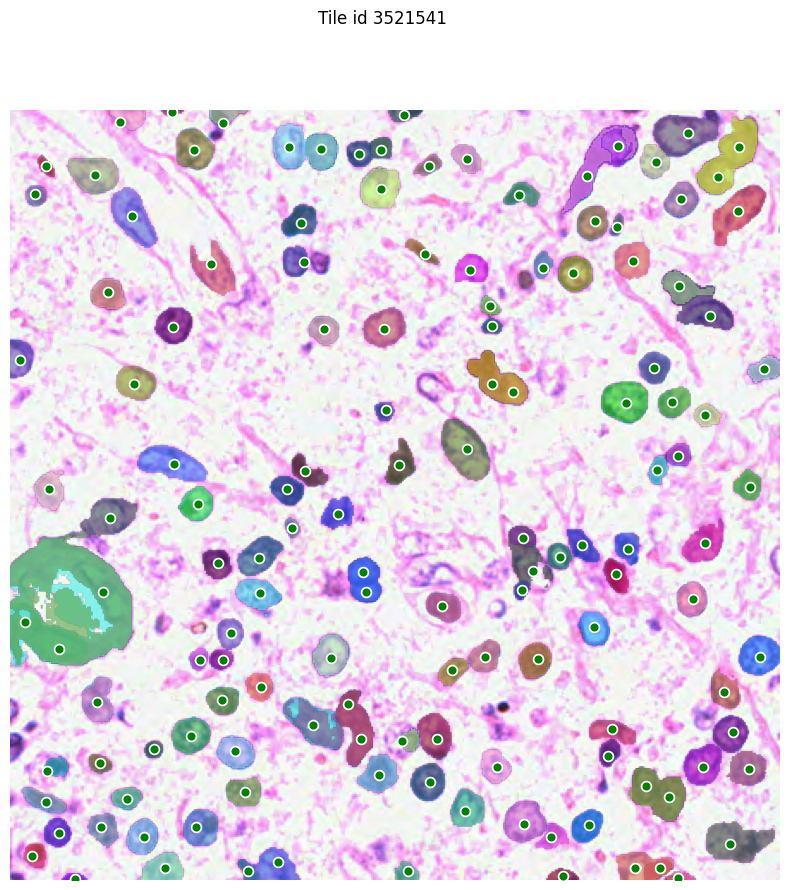

2024-04-02 12:29:07,593 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 12:29:07,594 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 6619042 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:29:07,595 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:07,600 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 6619042 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:29:07,600 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:07,601 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 6619042 AND coordinates LIKE '%POLYGON%';
2024-04-02 12:29:07,601 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:08,118 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 12:29:08.477 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 199 instances.


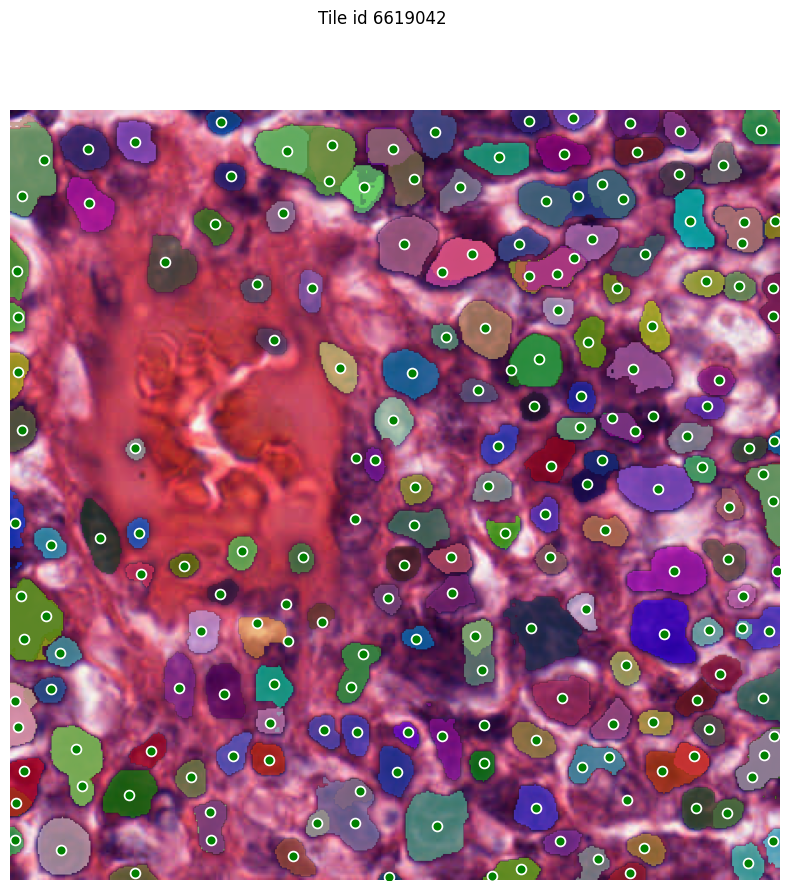

2024-04-02 12:29:32,756 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 12:29:32,757 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 65331257 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:29:32,758 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:32,763 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 65331257 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:29:32,764 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:32,765 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 65331257 AND coordinates LIKE '%POLYGON%';
2024-04-02 12:29:32,765 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:33,255 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 12:29:33.405 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 47 instances.


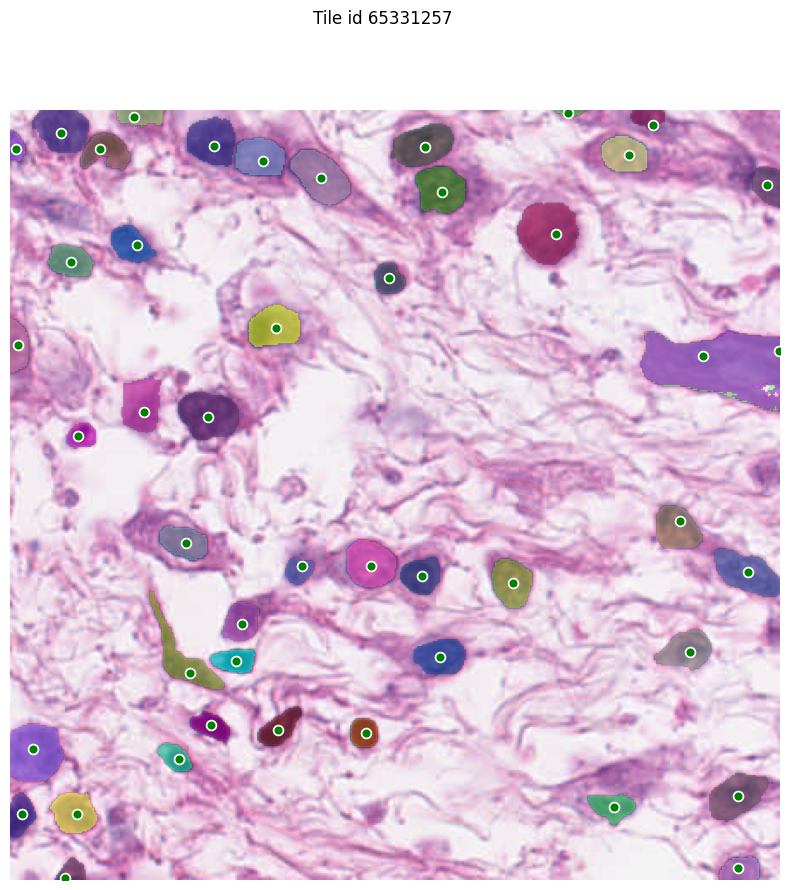

2024-04-02 12:29:39,674 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 12:29:39,675 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 67912873 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:29:39,675 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:39,680 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 67912873 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:29:39,680 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:39,681 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 67912873 AND coordinates LIKE '%POLYGON%';
2024-04-02 12:29:39,682 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:29:40,216 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 12:29:40.556 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 161 instances.


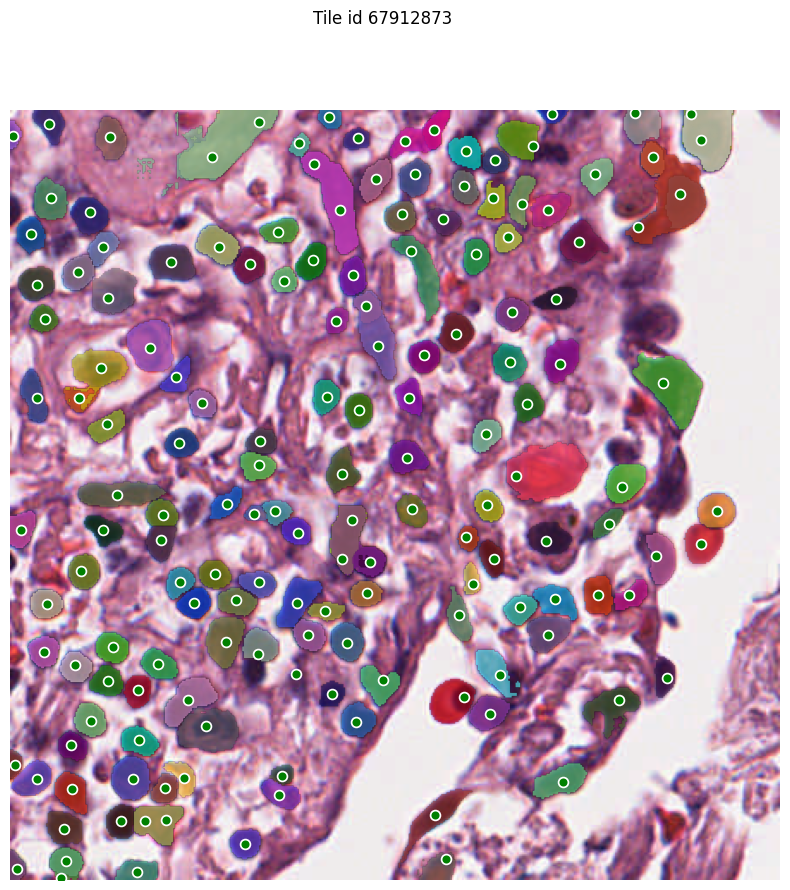

2024-04-02 12:30:00,083 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 12:30:00,084 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 84715806 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:30:00,084 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:30:00,089 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 84715806 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:30:00,089 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:30:00,090 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 84715806 AND coordinates LIKE '%POLYGON%';
2024-04-02 12:30:00,091 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:30:00,553 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 12:30:00.713 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 0 instances, keeping 90 instances.


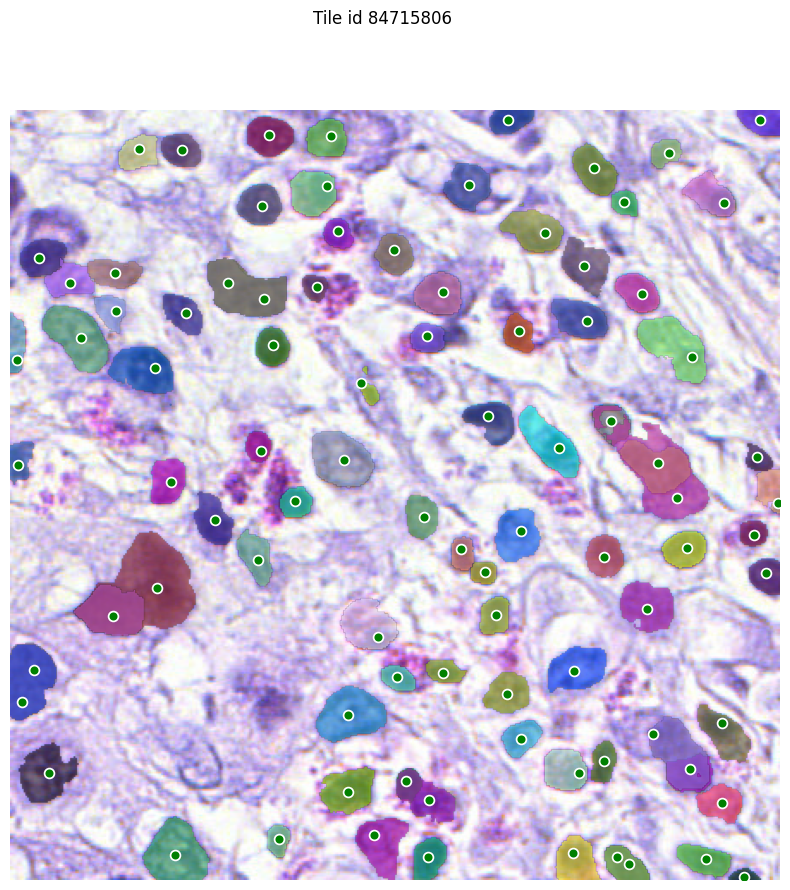

2024-04-02 12:30:11,979 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 12:30:11,980 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:30:11,981 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:30:11,986 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';")
2024-04-02 12:30:11,986 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:30:11,987 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';
2024-04-02 12:30:11,987 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 12:30:12,522 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 12:30:12.818 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 1 instances, keeping 178 instances.


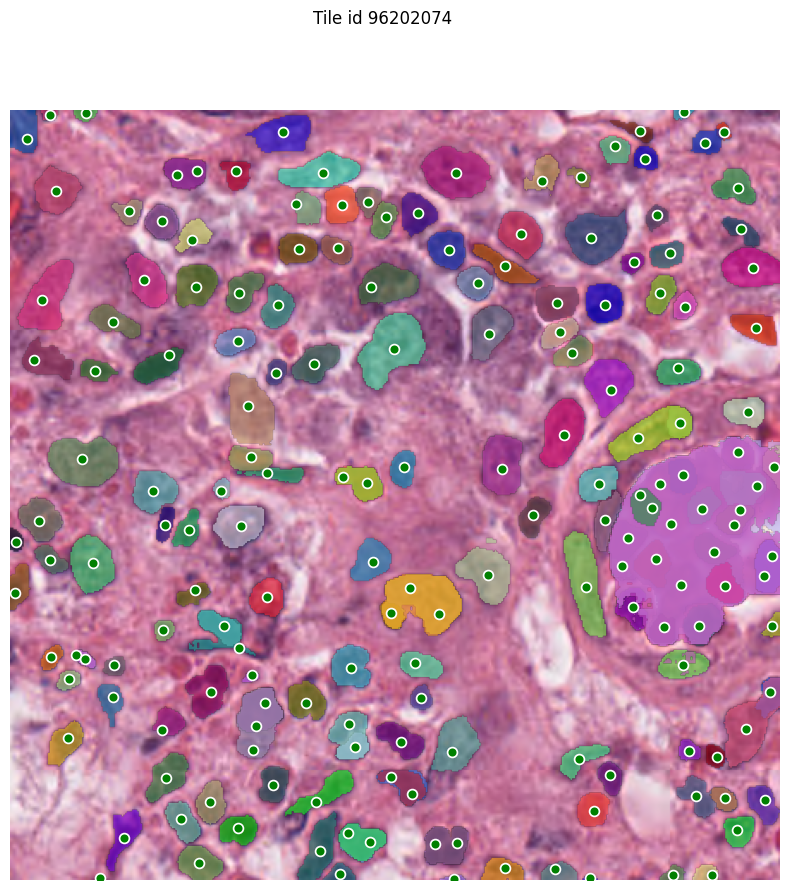

In [8]:
dataset_ids = np.arange(len(dataset_db.dataframe))

for idx_output in dataset_ids:
    img, target, tile_id = dataset_valid.__getitem__(int(idx_output))

    curr_output = outputs[int(tile_id)]

    img_numpy = img.numpy().transpose(1, 2, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_numpy)

    point_coords = np.squeeze(target["centroids"].numpy()) # (B, N_POINTS, 2)

    nb_points = point_coords.shape[0]

    masks = curr_output

    for idx_mask, mask in enumerate(masks):
        show_mask(mask, plt.gca(), random_color=True)

    input_label = np.ones(nb_points)
    show_points(point_coords, input_label, plt.gca(), marker_size=200)
    plt.suptitle(f"Tile id {tile_id}")
    plt.axis('off')
    plt.show()
    

In [6]:
from segment_anything.sam_histomics.compute_metrics import transform_masks_to_contours
import shapely

all_contours = transform_masks_to_contours(outputs[3521541])

In [10]:
all_contours[0][0]


array([[[35, 28]],

       [[34, 29]],

       [[34, 30]],

       [[34, 31]],

       [[33, 32]],

       [[34, 33]],

       [[34, 34]],

       [[34, 35]],

       [[35, 36]],

       [[35, 37]],

       [[36, 38]],

       [[37, 39]],

       [[37, 40]],

       [[38, 41]],

       [[39, 42]],

       [[39, 43]],

       [[40, 44]],

       [[41, 45]],

       [[42, 46]],

       [[43, 47]],

       [[44, 47]],

       [[45, 47]],

       [[46, 48]],

       [[47, 48]],

       [[48, 48]],

       [[49, 48]],

       [[50, 48]],

       [[51, 48]],

       [[52, 47]],

       [[53, 47]],

       [[54, 47]],

       [[55, 47]],

       [[56, 46]],

       [[57, 46]],

       [[58, 45]],

       [[59, 45]],

       [[60, 44]],

       [[61, 43]],

       [[61, 42]],

       [[62, 41]],

       [[62, 40]],

       [[62, 39]],

       [[62, 38]],

       [[62, 37]],

       [[62, 36]],

       [[62, 35]],

       [[62, 34]],

       [[61, 33]],

       [[61, 32]],

       [[60, 31]],



2024-04-02 16:59:55,391 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-02 16:59:55,392 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:55,393 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:55,398 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';")
2024-04-02 16:59:55,398 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:55,399 INFO sqlalchemy.engine.Engine SELECT * FROM pathologists_annotated_cells WHERE tile_id = 96202074 AND coordinates LIKE '%POLYGON%';
2024-04-02 16:59:55,400 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-02 16:59:55,902 INFO sqlalchemy.engine.Engine ROLLBACK


2024-04-02 16:59:56.200 | INFO     | histomics.data.labels:restrict_to_instances:749 - Removing 1 instances, keeping 178 instances.


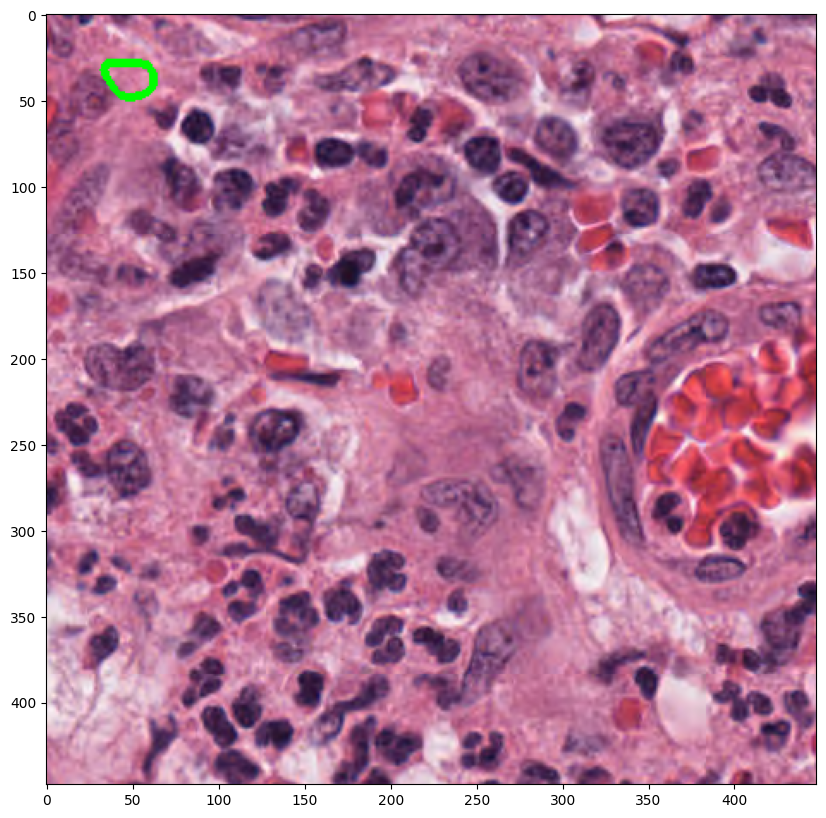

In [12]:
import cv2


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

img, target, tile_id = dataset_valid.__getitem__(int(5))
img_numpy = img.numpy().transpose(1, 2, 0)

cv2.drawContours(img_numpy, all_contours[0][0], -1, (0, 255, 0), 3)


plt.imshow(img_numpy)

#show_mask(outputs[3521541][0], ax, random_color=False)

plt.show()

